In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Based Library
import tensorflow as tf; print("tensorflow version : " + tf.__version__)
import keras; print("keras version : " + keras.__version__)
import cv2; print("OpenCv version : " + cv2.__version__)

tensorflow version : 1.14.0
keras version : 2.2.4
OpenCv version : 3.4.3


In [ ]:
# Processor

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17303033372571764462
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10152931151787144491
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6836003480546640770
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16366234008813981473
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
#Download and import ResNet50 model for transfer learning

from keras.applications.resnet50 import ResNet50, preprocess_input
#set image size
SIZE = 150

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(SIZE, SIZE, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
#Create trainable data and test data

from keras.preprocessing.image import ImageDataGenerator

#Train and test image directory
TRAIN_DIR = "drive/My Drive/Colab Notebooks/dataset/set3(150)/train"
VALID_DIR = "drive/My Drive/Colab Notebooks/dataset/set3(150)/test"


BATCH_SIZE = 8

#Image Prosessing for train data
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      zoom_range=0.2,
      horizontal_flip=False,      
      vertical_flip=True
    )

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

#Train data genarator
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(SIZE, SIZE), 
                                                    shuffle=True,
                                                    batch_size=BATCH_SIZE)
#Test data genarator
validation_generator = valid_datagen.flow_from_directory(VALID_DIR, 
                                                   target_size=(SIZE, SIZE), 
                                                   shuffle=False,
                                                   batch_size=BATCH_SIZE)

Found 374 images belonging to 4 classes.
Found 95 images belonging to 4 classes.


In [ ]:
#Freeze initial layer and add new layer

from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ["nothing", "box1", "box2", "box3"]
FC_LAYERS = [64, 64]
dropout = 0.5

#Define new layer for model

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))


W0730 05:45:46.208816 140125027100544 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
#Train the model and save it to google drive with check point

%%time
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#No of epochs
NUM_EPOCHS = 100


num_train_images = 374
num_valid_images = 95



adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

#Model saving path
filepath="drive/My Drive/Colab Notebooks/checkpoints/" + "ResNet50" + "_model_weights.h5"

#save max val_acc model
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

#Train the model
history = finetune_model.fit_generator(train_generator,
                                       epochs=NUM_EPOCHS,
                                       workers=8,
                                       steps_per_epoch=num_train_images // BATCH_SIZE,
                                       validation_data=validation_generator,
                                       validation_steps=num_valid_images // BATCH_SIZE,
                                       shuffle=True,
                                       callbacks=callbacks_list)



W0730 05:47:32.546414 140125027100544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0730 05:47:32.658083 140125027100544 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
46/46 [==============================] - 21s 454ms/step - loss: 2.2147 - acc: 0.2908 - val_loss: 1.4522 - val_acc: 0.3523

Epoch 00001: acc improved from -inf to 0.29076, saving model to drive/My Drive/Colab Notebooks/checkpoints/ResNet50_model_weights.h5
Epoch 2/100
46/46 [==============================] - 3s 72ms/step - loss: 1.6339 - acc: 0.3034 - val_loss: 1.2675 - val_acc: 0.3678

Epoch 00002: acc improved from 0.29076 to 0.30328, saving model to drive/My Drive/Colab Notebooks/checkpoints/ResNet50_model_weights.h5
Epoch 3/100
46/46 [==============================] - 2s 50ms/step - loss: 1.6017 - acc: 0.3415 - val_loss: 1.1607 - val_acc: 0.4598

Epoch 00003: acc improved from 0.30328 to 0.34153, saving model to drive/My Drive/Colab Notebooks/checkpoints/ResNet50_model_weights.h5
Epoch 4/100
46/46 [==============================] - 2s 50ms/step - loss: 1.4455 - acc: 0.3668 - val_loss: 1.0373 - val_acc: 0.5862

Epoch 00004: acc improved from 0.34153 to 0.36612, saving mod

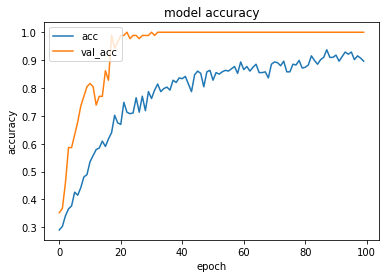

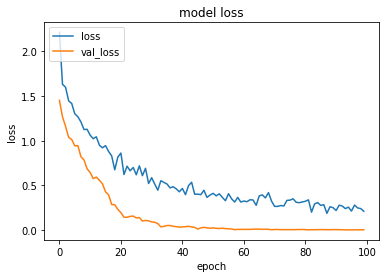

In [ ]:

def plot_history(history):
    #print(history.history.keys())


    # 精度の履歴をプロット
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='upper left')
    plt.show()


    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show()


# 学習履歴をプロット
plot_history(history)


validation_generator = valid_datagen.flow_from_directory(VALID_DIR, 
                                                   target_size=(SIZE, SIZE), 
                                                   shuffle=False,
                                                   batch_size=BATCH_SIZE)

---



In [ ]:
""""import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
#Confution Matrix and Classification Report

Y_pred = finetune_model.predict_generator(validation_generator, num_valid_images // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = class_list
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))""""

Confusion Matrix
[[ 0  0  8 18]
 [18  0  0  5]
 [ 8 15  0  0]
 [ 0  8 15  0]]
Classification Report
              precision    recall  f1-score   support

     nothing       0.00      0.00      0.00      26.0
        box1       0.00      0.00      0.00      23.0
        box2       0.00      0.00      0.00      23.0
        box3       0.00      0.00      0.00      23.0

    accuracy                           0.00      95.0
   macro avg       0.00      0.00      0.00      95.0
weighted avg       0.00      0.00      0.00      95.0

